In [ ]:
# keras相关包
from tensorflow.keras.applications import ResNet50
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# sklearn相关包
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.image import extract_patches_2d

import numpy as np
import cv2
import os
from imutils import paths
import progressbar

# 作图
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#设置随机种子
np.random.seed(161)

from keras.datasets import cifar10

#读取数据集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#归一化
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
# import cv2 as cv
# ishape = 256

# # 将CIFAR10转为所需尺寸
# x_train_resize = [cv.resize(i,(ishape,ishape), interpolation=cv.INTER_CUBIC) for i in x_train]
# x_test_resize = [cv.resize(i,(ishape,ishape), interpolation=cv.INTER_CUBIC) for i in x_test]

In [ ]:
# x_train=np.array(x_train).astype(float)

In [ ]:
# x_train_np = np.array(x_train)
# x_test_np = np.array(x_test)

In [ ]:
from keras.utils.np_utils import to_categorical

# Y 热编码
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


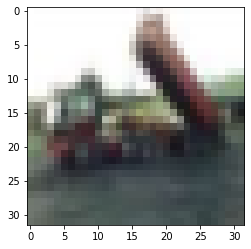

In [ ]:
plt.imshow(x_train_new[2])
plt.show()

In [ ]:
# 加载不包含top层的ResNet50作为baseModel
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(32, 32, 3)))

In [ ]:
def headmodel(baseModel):
    # 在baseModel基础上添加新的层
    headModel = baseModel.output
    
    # 新的 top 层
    headModel = Flatten()(headModel)
    headModel = Dense(10, activation="softmax")(headModel)

    return headModel

In [ ]:
headModel = headmodel(baseModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# 查看模型汇总信息
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
#图片增广
# 首先利用ImageDataGenerator类实例化一个图像生成器对象，设置图片增广相关的参数。
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [ ]:
# 保存模型快照的回调函数
modelname = "cifar10-resnet50-weights-{epoch:03d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(modelname, monitor="val_loss", mode="min", save_best_only=True)

In [ ]:
# 模型编译¶
# 编译模型需要指定优化器算法，loss函数和评估指标。之前的案例一直是二分类问题，所以loss函数使用的是binary_crossentropy，现在是多分类问题，loss函数使用categorical_crossentropy。

# 冻结住baseModel所有层的参数不学习
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# 编译
sgd = SGD(lr=0.01, decay=0.01 / 20, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


模型训练¶
在baseModel参数冻结的情况下，先训练20个epoch对微调的层进行参数学习，然后我们再把baseModel层解除冻结继续学习。 模型训练需要指定的参数有：

训练集(X_train,y_train)，这里我们使用的是图片生成对象的flow()方法循环的生成图片增广之后的数据对象
batch_size：适当的数量，太大了内存会暴
callbacks：回调函数，这里我们指定的是保存最佳模型快照的checkpoint这个回调函数
epochs：模型训练迭代的轮数
<!-- 我们把模型训练返回的结果保存为名称为H的对象，可以利用其中的一些数据，例如每一个epoch的acc和loss来作图。 -->

In [ ]:
H = model.fit_generator(aug.flow(x_train, y_train, batch_size=32),
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint],
                        steps_per_epoch=len(x_train) // 32,
                        epochs=20)


Epoch 1/20
   1/1562 [..............................] - ETA: 1:49 - loss: 7.1507 - accuracy: 0.2500

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1562/1562 [==============================] - 70s 45ms/step - loss: 3.4794 - accuracy: 0.4899 - val_loss: 3.2514 - val_accuracy: 0.5038


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
1562/1562 [==============================] - 70s 45ms/step - loss: 3.1200 - accuracy: 0.4917 - val_loss: 2.5628 - val_accuracy: 0.5243
Epoch 3/20
1562/1562 [==============================] - 69s 44ms/step - loss: 2.8171 - accuracy: 0.4957 - val_loss: 2.4141 - val_accuracy: 0.5168
Epoch 4/20
1562/1562 [==============================] - 70s 45ms/step - loss: 2.6014 - accuracy: 0.4942 - val_loss: 2.2064 - val_accuracy: 0.5288
Epoch 5/20
1562/1562 [==============================] - 69s 44ms/step - loss: 2.3827 - accuracy: 0.5023 - val_loss: 2.2859 - val_accuracy: 0.5066
Epoch 6/20
1562/1562 [==============================] - 69s 44ms/step - loss: 2.2449 - accuracy: 0.5065 - val_loss: 1.8721 - val_accuracy: 0.5428
Epoch 7/20
1562/1562 [==============================] - 69s 44ms/step - loss: 2.1231 - accuracy: 0.5092 - val_loss: 1.8140 - val_accuracy: 0.5340
Epoch 8/20
1562/1562 [==============================] - 69s 44ms/step - loss: 1.9985 - accuracy: 0.5117 - val_loss: 1.6595 -

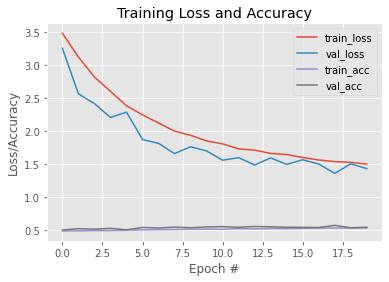

In [ ]:
# 绘制loss和accuracy曲线
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# 分类评估报告
preds = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),preds.argmax(axis=1), digits=4))

#  target_names=labelNames 

              precision    recall  f1-score   support

           0     0.6227    0.6370    0.6298      1000
           1     0.6916    0.5270    0.5982      1000
           2     0.5693    0.3450    0.4296      1000
           3     0.4912    0.1950    0.2792      1000
           4     0.6427    0.4030    0.4954      1000
           5     0.3699    0.6480    0.4709      1000
           6     0.4505    0.8370    0.5857      1000
           7     0.7459    0.4520    0.5629      1000
           8     0.6447    0.7040    0.6730      1000
           9     0.5529    0.7060    0.6201      1000

    accuracy                         0.5454     10000
   macro avg     0.5781    0.5454    0.5345     10000
weighted avg     0.5781    0.5454    0.5345     10000



In [ ]:
# 允许baseModel所有层的参数都可学习
for layer in baseModel.layers:
    layer.trainable = True

In [ ]:
# 保存模型快照的回调函数
modelname = "final_cifar10-resnet50-weights-{epoch:03d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(modelname, monitor="val_loss", mode="min", save_best_only=True)

In [ ]:
# 编译
sgd = SGD(lr=0.001, decay=0.001 / 20, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
H = model.fit_generator(aug.flow(x_train, y_train, batch_size=32),
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint],
                        steps_per_epoch=len(x_train) // 32,
                        epochs=20)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1562/1562 [==============================] - 178s 109ms/step - loss: 1.6682 - accuracy: 0.4467 - val_loss: 1.1564 - val_accuracy: 0.6051


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
1562/1562 [==============================] - 169s 108ms/step - loss: 1.1704 - accuracy: 0.5998 - val_loss: 1.0396 - val_accuracy: 0.6502
Epoch 3/20
1562/1562 [==============================] - 172s 110ms/step - loss: 1.0096 - accuracy: 0.6552 - val_loss: 0.7757 - val_accuracy: 0.7388
Epoch 4/20
1562/1562 [==============================] - 168s 108ms/step - loss: 0.9075 - accuracy: 0.6896 - val_loss: 0.7659 - val_accuracy: 0.7403
Epoch 5/20
1562/1562 [==============================] - 170s 108ms/step - loss: 0.8349 - accuracy: 0.7139 - val_loss: 1.0663 - val_accuracy: 0.6875
Epoch 6/20
1562/1562 [==============================] - 169s 108ms/step - loss: 0.7795 - accuracy: 0.7329 - val_loss: 0.8515 - val_accuracy: 0.7037
Epoch 7/20
1562/1562 [==============================] - 167s 107ms/step - loss: 0.7368 - accuracy: 0.7492 - val_loss: 0.7598 - val_accuracy: 0.7544
Epoch 8/20
1562/1562 [==============================] - 167s 107ms/step - loss: 0.7058 - accuracy: 0.7583 - val_

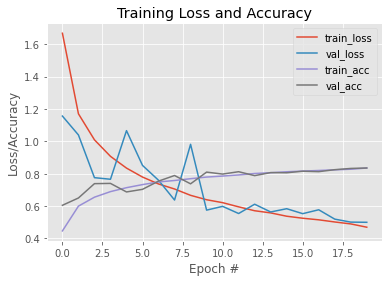

In [ ]:
# 绘制loss和accuracy曲线
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# 分类评估报告
preds = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),preds.argmax(axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.8894    0.8520    0.8703      1000
           1     0.8989    0.9070    0.9029      1000
           2     0.8480    0.7700    0.8071      1000
           3     0.7422    0.6390    0.6867      1000
           4     0.8189    0.8140    0.8164      1000
           5     0.8164    0.7250    0.7680      1000
           6     0.7508    0.9430    0.8360      1000
           7     0.8550    0.8960    0.8750      1000
           8     0.9294    0.8950    0.9119      1000
           9     0.8197    0.9140    0.8643      1000

    accuracy                         0.8355     10000
   macro avg     0.8369    0.8355    0.8339     10000
weighted avg     0.8369    0.8355    0.8339     10000

